## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler

## Data Retrieval

In [2]:
# Specify the file paths
train_path = "./train.csv"
valid_path = "./valid.csv"
test_path = "./test.csv"

# Load the CSV files into Pandas DataFrames
train = pd.read_csv(train_path)
valid = pd.read_csv(valid_path)
test = pd.read_csv(test_path)

## Preprocessing

In [3]:
train_ = train.copy()
valid_ = valid.copy()
test_ = test.copy()
test_ = test_.drop(columns=['ID'])

In [4]:
labels = ['label_1', 'label_2', 'label_3', 'label_4']

In [5]:
# dict to store train and valid dataset for each label
train_features = {}
train_label = {}
valid_features = {}
valid_label = {}

# seperate the train and valid datasets into labels
# remove the rows where label is NaN

for label in labels:
    # Filter rows where the specific label column does not have missing values
    train_temp = train_[train_[label].notna()]
    valid_temp = valid_[valid_[label].notna()]

    # Separate the features and labels
    train_features[label] = train_temp.drop(labels, axis=1)
    train_label[label] = train_temp[label]
    valid_features[label] = valid_temp.drop(labels, axis=1)
    valid_label[label] = valid_temp[label]

## Common Methods

### Classifier

In [6]:
models = ["svm", "rfc", "lr", "cb", "knn"]

In [7]:
def classify(model, L, X_train, X_valid, y_train, y_valid):
  classifier = None
  class_weight = None if L == 'label_1' else 'balanced'
  
  if model == "svm":
    classifier = SVC(kernel='linear', class_weight=class_weight)

  elif model == "rfc":
    classifier = RandomForestClassifier(class_weight=class_weight)

  elif model == "lr":
    classifier = LogisticRegression(class_weight=class_weight, max_iter=1000)

  elif model == "cb":
    classifier = CatBoostClassifier(class_weights='Auto', iterations=100)
                                    
  elif model == "knn":
    classifier = KNeighborsClassifier(n_neighbors=1)

  

  if model == "knn": # KNN
    classifier.fit(np.array(X_train[L]), y_train[L])
    y_pred = classifier.predict(np.array(X_valid[L]))
  else:
    classifier.fit(X_train[L], y_train[L])
    y_pred = classifier.predict(X_valid[L])

  accuracy = accuracy_score(y_valid[L], y_pred)
  print(f"{model} Accuracy Score for {L} = %.2f%%" % (accuracy * 100))

  return accuracy

### Random grid search with cross validation

In [8]:
def random_grid_search_classifier(classifier, X_train, y_train, param_distributions):

    # Create a random search object with cross-validation
    random_search = RandomizedSearchCV(
        estimator=classifier,
        param_distributions=param_distributions,
        scoring='accuracy',
        cv=2,
        verbose=1,
        n_jobs=-1,
        n_iter=5,
        random_state=42)
    
    # Fit the random search to the training data
    random_search.fit(X_train, y_train)

    # Get the best model from the random search
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    best_accuracy = random_search.best_score_

    return best_model, best_accuracy, best_params

### Grid Search with cross validation

In [9]:
def grid_search_classifier(classifier, X_train, y_train, X_valid, y_valid, param_grid):

    # Create a grid search object with cross-validation
    grid_search = GridSearchCV(
        classifier, 
        param_grid, 
        cv=2, 
        dddn_jobs=-1)

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Make predictions on the testing data using the best model
    y_pred = best_model.predict(X_valid)

    # Calculate accuracy score
    accuracy = accuracy_score(y_valid, y_pred)

    # Return accuracy and best hyperparameters
    return accuracy, grid_search.best_params_

### K fold cross validation

In [10]:
def k_fold_cross_validation(clasifier, k, X_train, y_train):

    scores = cross_val_score(clasifier, X_train, y_train, cv=k)
    mean_score = np.mean(scores)
    std_deviation = np.std(scores)
    print("Cross-Validation Scores:", scores)
    print("Mean Score:", mean_score)
    print("Standard Deviation:", std_deviation)

### Get prediction for classifier

In [11]:
def get_classifier_predictions(model, x_valid, y_valid):

    y_pred = model.predict(x_valid)
    accuracy = accuracy_score(y_valid, y_pred)

    return accuracy

# Label 1

In [12]:
train_features['label_1'].head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
0,0.019301,0.059756,0.081375,0.057481,-0.068440,-0.165913,0.035643,-0.091138,0.021688,0.057158,...,-0.108481,0.124449,0.124765,-0.235671,-0.035576,0.127319,0.098128,-0.058787,0.100971,-0.047754
1,0.049741,0.090030,0.035118,-0.013676,-0.194317,-0.101763,0.085875,-0.081317,0.112418,0.120523,...,-0.025115,0.186260,0.085101,-0.365903,0.020538,0.058968,0.029803,0.111324,0.036727,0.031927
2,0.019212,0.087779,0.093907,-0.033738,-0.141409,-0.062881,-0.071402,-0.006599,0.020372,-0.027777,...,-0.058567,0.019542,0.144256,-0.123374,0.119645,-0.040861,0.000548,-0.061003,-0.042450,0.063340
3,0.070283,0.049040,0.042126,0.122637,-0.056964,-0.113700,0.108454,0.051336,0.086610,0.141578,...,-0.124006,0.117235,-0.038984,-0.028714,-0.124494,-0.169225,-0.046391,0.148787,0.014616,-0.140644
4,0.028864,0.165634,0.016302,0.036117,-0.028871,-0.147748,0.053180,0.025071,-0.004200,-0.022183,...,-0.112267,0.029716,0.077643,-0.182132,-0.124862,0.044907,0.084005,-0.038450,0.084371,-0.072146


d:\Applications\Mambaforge\envs\env_gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Applications\Mambaforge\envs\env_gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Applications\Mambaforge\envs\env_gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='label_1', ylabel='count'>

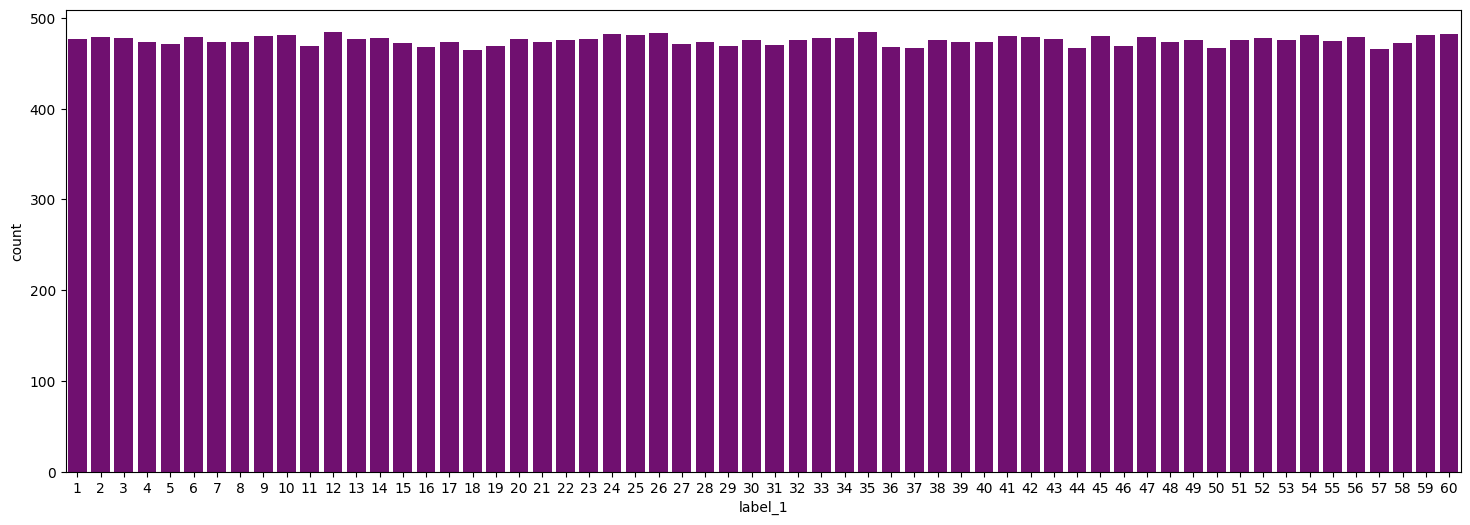

In [13]:
plt.figure(figsize=(18, 6))
sn.countplot(data=train_label, x='label_1', color='purple')

## Before Feature Engineering

In [14]:
classify(models[0], 'label_1', train_features, valid_features, train_label, valid_label)

svm Accuracy Score for label_1 = 96.93%


0.9693333333333334

In [15]:
classify(models[1], 'label_1', train_features, valid_features, train_label, valid_label)

rfc Accuracy Score for label_1 = 88.13%


0.8813333333333333

In [16]:
classify(models[4], 'label_1', train_features, valid_features, train_label, valid_label)

knn Accuracy Score for label_1 = 91.07%


0.9106666666666666

## Feature Engineering

### Standardization

In [17]:
test.head()

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
0,1,0.013112,0.130904,0.020284,0.063018,-0.034321,-0.073516,-0.030659,-0.064994,0.024153,...,0.037803,0.241121,0.079949,-0.186099,-0.096718,0.126006,-0.023069,0.190374,0.146516,0.038047
1,2,0.005934,0.138592,-0.007000,0.055925,-0.021927,-0.084788,0.013339,0.060811,-0.011344,...,-0.098701,0.042921,0.018571,-0.114785,-0.105186,0.059050,0.021443,0.013027,0.046826,-0.026682
2,3,-0.067210,0.078710,-0.044344,0.101248,-0.074331,-0.088951,0.074616,0.007231,0.021091,...,0.029569,0.053370,0.096232,-0.369018,-0.066708,-0.003730,-0.063339,-0.044497,-0.024363,-0.042594
3,4,-0.005678,0.060703,0.033954,0.068771,-0.039923,-0.186583,0.014921,0.020791,0.017441,...,-0.095406,0.018405,-0.018047,-0.080393,-0.114030,0.048255,0.033839,0.035026,-0.047988,-0.038252
4,5,-0.076360,0.061095,-0.004938,0.066692,-0.040454,-0.005141,-0.003213,0.025721,0.083558,...,-0.003129,0.045479,0.057146,-0.194466,0.000739,0.018702,0.013192,-0.038486,0.033358,-0.038452


In [18]:
# scaler = RobustScaler()
scaler = StandardScaler()

# Fit and transform the training data
train_standardized = scaler.fit_transform(train_features['label_1'])

# Transform the validation data using the same scaler
valid_standardized = scaler.transform(valid_features['label_1'])

# Transform the test data using the same scaler
test_standardized = scaler.transform(test_)

### PCA

In [19]:
threshold = 0.96

pca_train = {}
pca_valid = {}
pca_test = {}

pca = PCA(threshold, svd_solver='full')


pca_train['label_1'] = pca.fit_transform(train_standardized)
pca_valid['label_1'] = pca.transform(valid_standardized)
pca_test['label_1'] = pca.transform(test_standardized)

explained_variance = pca.explained_variance_ratio_

retained_features_len = len(explained_variance)
print("Number of componenets for train data:", retained_features_len)

Number of componenets for train data: 350


In [20]:
classify(models[0], 'label_1', pca_train, pca_valid, train_label, valid_label)

svm Accuracy Score for label_1 = 93.33%


0.9333333333333333

In [21]:
classify(models[1], 'label_1', pca_train, pca_valid, train_label, valid_label)

rfc Accuracy Score for label_1 = 79.73%


0.7973333333333333

In [23]:
classify(models[4], 'label_1', pca_train, pca_valid, train_label, valid_label)

knn Accuracy Score for label_1 = 88.13%


0.8813333333333333

#### Since the higher accuracy is given by SVM we can use svm as the classifier. Then we can optimize it using hyperparameter tuning.

## Hyperparameter Tuning

In [45]:
X_train = pca_train['label_1']
X_valid = pca_valid['label_1']
y_train = train_label['label_1']
y_valid = valid_label['label_1']

In [25]:
param_distributions = {
    'C': np.logspace(-3, 3, 7),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': np.logspace(-3, 3, 7)
}

# Create an instance of the classifier
classifier = SVC()

# Call the function to perform random search and get the best accuracy and hyperparameters
best_model, best_accuracy, best_hyperparameters = random_grid_search_classifier(
    classifier, 
    X_train, 
    y_train, 
    param_distributions)

print("Best Model:", best_model)
print("Best Accuracy: %.2f%%" % (best_accuracy * 100))
print("Best Hyperparameters:", best_hyperparameters)


Fitting 2 folds for each of 5 candidates, totalling 10 fits


Best Model: SVC(gamma=1000.0, kernel='poly')
Best Accuracy: 92.24%
Best Hyperparameters: {'kernel': 'poly', 'gamma': 1000.0, 'C': 1.0}


In [26]:
best_models = {}

best_models['label_1'] = best_model

In [47]:
accuracy = get_classifier_predictions(best_models['label_1'], X_valid, y_valid)
print("Accuracy: %.2f%%" % (accuracy * 100))

Accuracy: 96.00%


In [28]:
classifier = SVC(**best_hyperparameters)

k_fold_cross_validation(classifier, 5, X_train, y_train)

Cross-Validation Scores: [0.94793128 0.94670407 0.94319776 0.94109397 0.94512623]
Mean Score: 0.9448106591865357
Standard Deviation: 0.002442870048857003


# Label 2

In [29]:
train_features['label_2'].head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
480,-0.037427,0.068284,-0.100538,0.076783,-0.113147,-0.079453,0.106947,0.011906,-0.047519,0.022915,...,0.061858,0.086089,0.004285,-0.325560,-0.035784,0.033521,-0.025551,0.083790,-0.027678,-0.008546
481,0.024931,0.045966,0.016385,0.028214,-0.092396,-0.053490,-0.018101,0.053902,0.080196,0.010693,...,0.048435,0.127840,0.060487,-0.268356,-0.001359,0.019178,0.068597,0.066214,0.141953,0.075839
482,0.025077,0.082511,0.074441,0.124308,-0.037937,-0.089271,0.012489,-0.036005,-0.023984,-0.010576,...,-0.081554,0.121891,0.042131,-0.019572,-0.095350,0.087392,0.007523,0.030705,0.086901,0.031186
483,0.030733,0.060249,0.099119,0.087801,-0.035729,-0.152115,0.032606,0.024821,0.032655,0.053826,...,0.039644,0.094773,-0.043471,-0.177032,-0.091252,0.031182,-0.034731,0.004988,0.143666,-0.012354
484,0.012062,0.068691,0.051343,0.049753,0.006491,-0.107100,0.076212,0.004650,0.113739,0.004015,...,-0.028502,0.123084,0.046536,-0.053508,-0.025445,0.062129,-0.034741,0.042223,-0.024982,0.132500


d:\Applications\Mambaforge\envs\env_gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Applications\Mambaforge\envs\env_gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Applications\Mambaforge\envs\env_gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='label_2', ylabel='count'>

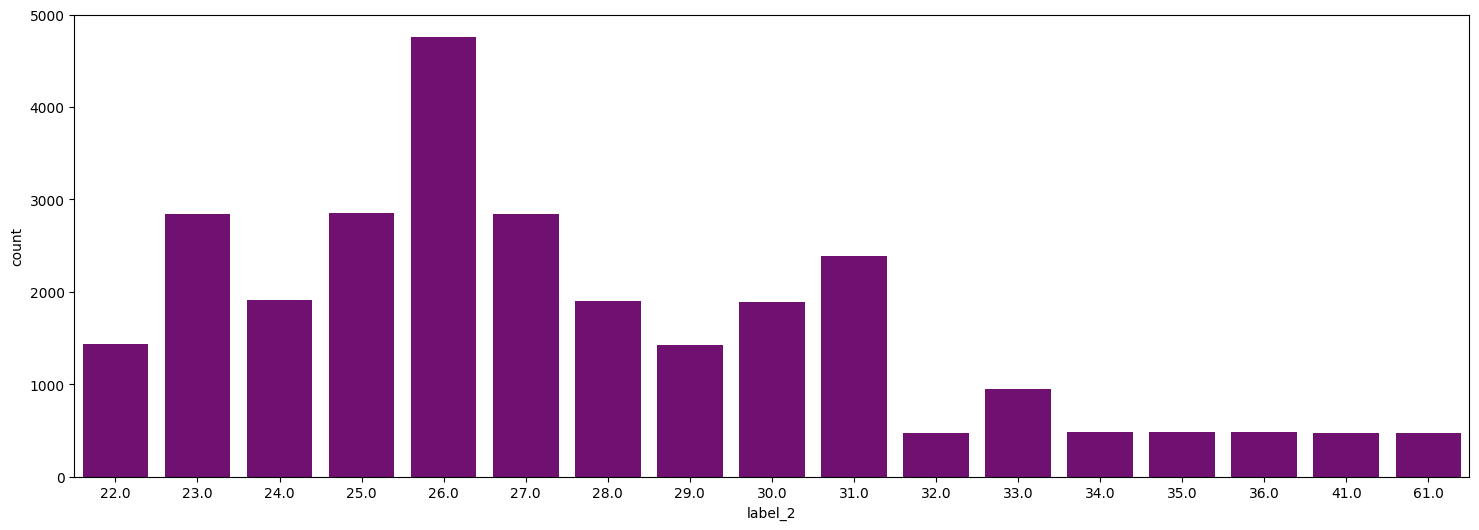

In [30]:
plt.figure(figsize=(18, 6))
sn.countplot(data=train_label, x='label_2', color='purple')

## Before Feature Engineering

In [31]:
classify(models[0], 'label_2', train_features, valid_features, train_label, valid_label)

svm Accuracy Score for label_2 = 82.34%


0.8233695652173914

In [32]:
classify(models[1], 'label_2', train_features, valid_features, train_label, valid_label)

rfc Accuracy Score for label_2 = 75.14%


0.751358695652174

In [33]:
classify(models[4], 'label_2', train_features, valid_features, train_label, valid_label)

knn Accuracy Score for label_2 = 92.12%


0.9211956521739131

## Feature Engineering

### Standardization

In [34]:
# scaler = RobustScaler()
scaler = StandardScaler()

# Fit and transform the training data
train_standardized = scaler.fit_transform(train_features['label_2'])

# Transform the validation data using the same scaler
valid_standardized = scaler.transform(valid_features['label_2'])

# Transform the test data using the same scaler
test_standardized = scaler.transform(test_)

### PCA

In [35]:
threshold = 0.96
pca = PCA(threshold, svd_solver='full')


pca_train['label_2'] = pca.fit_transform(train_standardized)
pca_valid['label_2'] = pca.transform(valid_standardized)
pca_test['label_2'] = pca.transform(test_standardized)

explained_variance = pca.explained_variance_ratio_

retained_features_len = len(explained_variance)
print("Number of componenets for train data:", retained_features_len)

Number of componenets for train data: 350


In [36]:
classify(models[0], 'label_2', pca_train, pca_valid, train_label, valid_label)

svm Accuracy Score for label_2 = 80.57%


0.8057065217391305

In [37]:
classify(models[1], 'label_2', pca_train, pca_valid, train_label, valid_label)

rfc Accuracy Score for label_2 = 63.32%


0.6331521739130435

In [38]:
classify(models[4], 'label_2', pca_train, pca_valid, train_label, valid_label) 

knn Accuracy Score for label_2 = 89.13%


0.8913043478260869

## Hyperparameter Tuning

In [48]:
X_train = pca_train['label_2']
X_valid = pca_valid['label_2']
y_train = train_label['label_2']
y_valid = valid_label['label_2']

In [40]:
param_distributions = {
    'C': np.logspace(-3, 3, 7),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': np.logspace(-3, 3, 7),
    'class_weight': ['balanced']
}

# Create an instance of the classifier
classifier = SVC()

# Call the function to perform random search and get the best accuracy and hyperparameters
best_model, best_accuracy, best_hyperparameters = random_grid_search_classifier(
    classifier, 
    X_train, 
    y_train,
    param_distributions)

print("Best Model:", best_model)
print("Best Accuracy: %.2f%%" % (best_accuracy * 100))
print("Best Hyperparameters:", best_hyperparameters)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


Best Model: SVC(C=0.1, class_weight='balanced', gamma=1.0, kernel='poly')
Best Accuracy: 26.62%
Best Hyperparameters: {'kernel': 'poly', 'gamma': 1.0, 'class_weight': 'balanced', 'C': 0.1}


In [49]:
best_models['label_2'] = best_model

In [50]:
accuracy = get_classifier_predictions(best_models['label_2'], X_valid, y_valid)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.48%


In [51]:
classifier = SVC(**best_hyperparameters)

k_fold_cross_validation(classifier, 5, X_train, y_train)

Cross-Validation Scores: [0.45827389 0.69561341 0.71968616 0.72628388 0.50499287]
Mean Score: 0.6209700427960058
Standard Deviation: 0.11517660418375814


# Label 3

In [52]:
train_features['label_3'].head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
0,0.019301,0.059756,0.081375,0.057481,-0.068440,-0.165913,0.035643,-0.091138,0.021688,0.057158,...,-0.108481,0.124449,0.124765,-0.235671,-0.035576,0.127319,0.098128,-0.058787,0.100971,-0.047754
1,0.049741,0.090030,0.035118,-0.013676,-0.194317,-0.101763,0.085875,-0.081317,0.112418,0.120523,...,-0.025115,0.186260,0.085101,-0.365903,0.020538,0.058968,0.029803,0.111324,0.036727,0.031927
2,0.019212,0.087779,0.093907,-0.033738,-0.141409,-0.062881,-0.071402,-0.006599,0.020372,-0.027777,...,-0.058567,0.019542,0.144256,-0.123374,0.119645,-0.040861,0.000548,-0.061003,-0.042450,0.063340
3,0.070283,0.049040,0.042126,0.122637,-0.056964,-0.113700,0.108454,0.051336,0.086610,0.141578,...,-0.124006,0.117235,-0.038984,-0.028714,-0.124494,-0.169225,-0.046391,0.148787,0.014616,-0.140644
4,0.028864,0.165634,0.016302,0.036117,-0.028871,-0.147748,0.053180,0.025071,-0.004200,-0.022183,...,-0.112267,0.029716,0.077643,-0.182132,-0.124862,0.044907,0.084005,-0.038450,0.084371,-0.072146


d:\Applications\Mambaforge\envs\env_gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Applications\Mambaforge\envs\env_gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Applications\Mambaforge\envs\env_gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


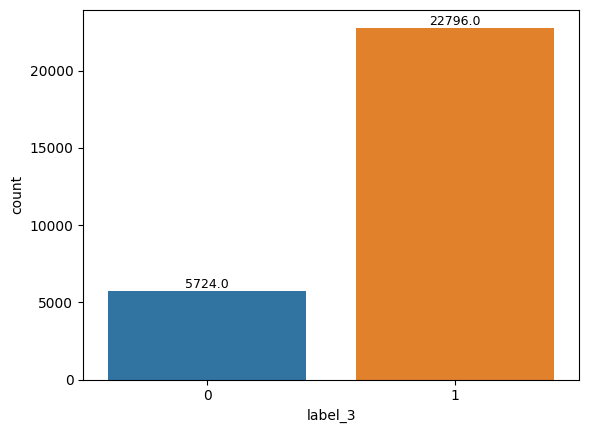

In [53]:
x = sn.countplot(x='label_3', data=train_label)

for p in x.patches:
    x.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black')

In [54]:
sampler = RandomOverSampler(random_state=0, sampling_strategy=0.80)

ros_train_features = {}
ros_train_label = {}

ros_train_features['label_3'], ros_train_label['label_3'] = sampler.fit_resample(train_features['label_3'], train_label['label_3'])

d:\Applications\Mambaforge\envs\env_gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Applications\Mambaforge\envs\env_gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Applications\Mambaforge\envs\env_gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


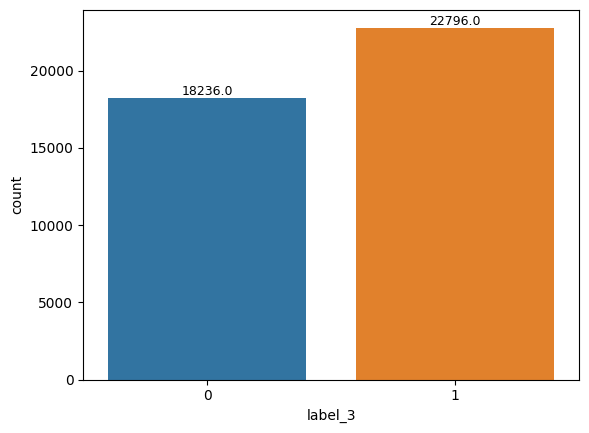

In [55]:
x = sn.countplot(x='label_3', data=ros_train_label)

for p in x.patches:
    x.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black')

## Before Feature Engineering

In [56]:
classify(models[0], 'label_3', train_features, valid_features, train_label, valid_label)

svm Accuracy Score for label_3 = 99.33%


0.9933333333333333

In [57]:
classify(models[2], 'label_3', train_features, valid_features, train_label, valid_label)

lr Accuracy Score for label_3 = 99.20%


0.992

In [58]:
classify(models[4], 'label_3', ros_train_features, valid_features, ros_train_label, valid_label)

knn Accuracy Score for label_3 = 99.07%


0.9906666666666667

## Feature Engineering

### Standardization

In [59]:
# scaler = RobustScaler()
scaler = StandardScaler()

# Fit and transform the training data
train_standardized = scaler.fit_transform(train_features['label_3'])

# Transform the validation data using the same scaler
valid_standardized = scaler.transform(valid_features['label_3'])

# Transform the test data using the same scaler
test_standardized = scaler.transform(test_)

In [60]:
# standardize the random oversampled data
scaler = RobustScaler()

ros_train_standardized = scaler.fit_transform(ros_train_features['label_3'])
ros_valid_standardized = scaler.transform(valid_features['label_3'])
ros_test_standardized = scaler.transform(test_)

### PCA

In [61]:
threshold = 0.96
pca = PCA(threshold, svd_solver='full')


pca_train['label_3'] = pca.fit_transform(train_standardized)
pca_valid['label_3'] = pca.transform(valid_standardized)
pca_test['label_3'] = pca.transform(test_standardized)

explained_variance = pca.explained_variance_ratio_

retained_features_len = len(explained_variance)
print("Number of componenets for train data:", retained_features_len)

Number of componenets for train data: 350


In [62]:
# PCA with oversampled data
pca = PCA(threshold, svd_solver='full')

pca_ros_train = {}
pca_ros_valid = {}
pca_ros_test = {}

pca_ros_train['label_3'] = pca.fit_transform(ros_train_standardized)
pca_ros_valid['label_3'] = pca.transform(ros_valid_standardized)
pca_ros_test['label_3'] = pca.transform(ros_test_standardized)

explained_variance = pca.explained_variance_ratio_

retained_features_len = len(explained_variance)
print("Number of componenets for oversampled train data:", retained_features_len)

Number of componenets for oversampled train data: 343


In [63]:
classify(models[0], 'label_3', pca_train, pca_valid, train_label, valid_label)

svm Accuracy Score for label_3 = 99.60%


0.996

In [64]:
classify(models[2], 'label_3', pca_train, pca_valid, train_label, valid_label)

lr Accuracy Score for label_3 = 99.47%


0.9946666666666667

In [65]:
classify(models[4], 'label_3', pca_ros_train, pca_ros_valid, ros_train_label, valid_label)

knn Accuracy Score for label_3 = 98.80%


0.988

## Hyperparameter Tuning

In [66]:
X_train = pca_train['label_3']
X_valid = pca_valid['label_3']
y_train = train_label['label_3']
y_valid = valid_label['label_3']

In [67]:
param_distributions = {
    'C': np.logspace(-3, 3, 7),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': np.logspace(-3, 3, 7),
    'class_weight': ['balanced']
}

# Create an instance of the classifier
classifier = SVC()

# Call the function to perform random search and get the best accuracy and hyperparameters
best_model, best_accuracy, best_hyperparameters = random_grid_search_classifier(
    classifier, 
    X_train, 
    y_train, 
    param_distributions)

print("Best Model:", best_model)
print("Best Accuracy: %.2f%%" % (best_accuracy * 100))
print("Best Hyperparameters:", best_hyperparameters)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


Best Model: SVC(C=1000.0, class_weight='balanced', gamma=0.01, kernel='linear')
Best Accuracy: 96.65%
Best Hyperparameters: {'kernel': 'linear', 'gamma': 0.01, 'class_weight': 'balanced', 'C': 1000.0}


In [68]:
best_models['label_3'] = best_model

In [69]:
accuracy = get_classifier_predictions(best_models['label_3'], X_valid, y_valid)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.20%


In [70]:
classifier = SVC(**best_hyperparameters)

k_fold_cross_validation(classifier, 5, X_train, y_train)

Cross-Validation Scores: [0.95774895 0.99333801 0.98001403 0.97685835 0.99298738]
Mean Score: 0.9801893408134642
Standard Deviation: 0.013048943945251341


# Label 4

In [71]:
train_features['label_4'].head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
0,0.019301,0.059756,0.081375,0.057481,-0.068440,-0.165913,0.035643,-0.091138,0.021688,0.057158,...,-0.108481,0.124449,0.124765,-0.235671,-0.035576,0.127319,0.098128,-0.058787,0.100971,-0.047754
1,0.049741,0.090030,0.035118,-0.013676,-0.194317,-0.101763,0.085875,-0.081317,0.112418,0.120523,...,-0.025115,0.186260,0.085101,-0.365903,0.020538,0.058968,0.029803,0.111324,0.036727,0.031927
2,0.019212,0.087779,0.093907,-0.033738,-0.141409,-0.062881,-0.071402,-0.006599,0.020372,-0.027777,...,-0.058567,0.019542,0.144256,-0.123374,0.119645,-0.040861,0.000548,-0.061003,-0.042450,0.063340
3,0.070283,0.049040,0.042126,0.122637,-0.056964,-0.113700,0.108454,0.051336,0.086610,0.141578,...,-0.124006,0.117235,-0.038984,-0.028714,-0.124494,-0.169225,-0.046391,0.148787,0.014616,-0.140644
4,0.028864,0.165634,0.016302,0.036117,-0.028871,-0.147748,0.053180,0.025071,-0.004200,-0.022183,...,-0.112267,0.029716,0.077643,-0.182132,-0.124862,0.044907,0.084005,-0.038450,0.084371,-0.072146


d:\Applications\Mambaforge\envs\env_gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Applications\Mambaforge\envs\env_gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Applications\Mambaforge\envs\env_gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='label_4', ylabel='count'>

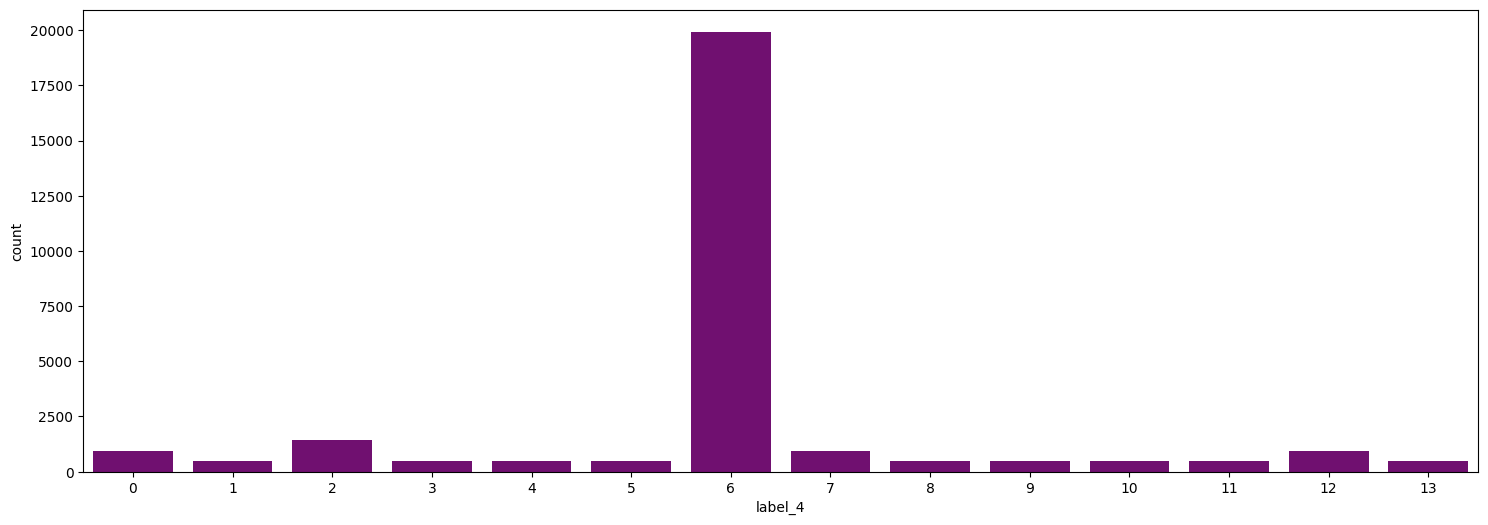

In [72]:
plt.figure(figsize=(18, 6))
sn.countplot(data=train_label, x='label_4', color='purple')

In [73]:
sampler = RandomOverSampler(random_state=0)

ros_train_features['label_4'], ros_train_label['label_4'] = sampler.fit_resample(train_features['label_4'], train_label['label_4'])

d:\Applications\Mambaforge\envs\env_gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Applications\Mambaforge\envs\env_gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Applications\Mambaforge\envs\env_gpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='label_4', ylabel='count'>

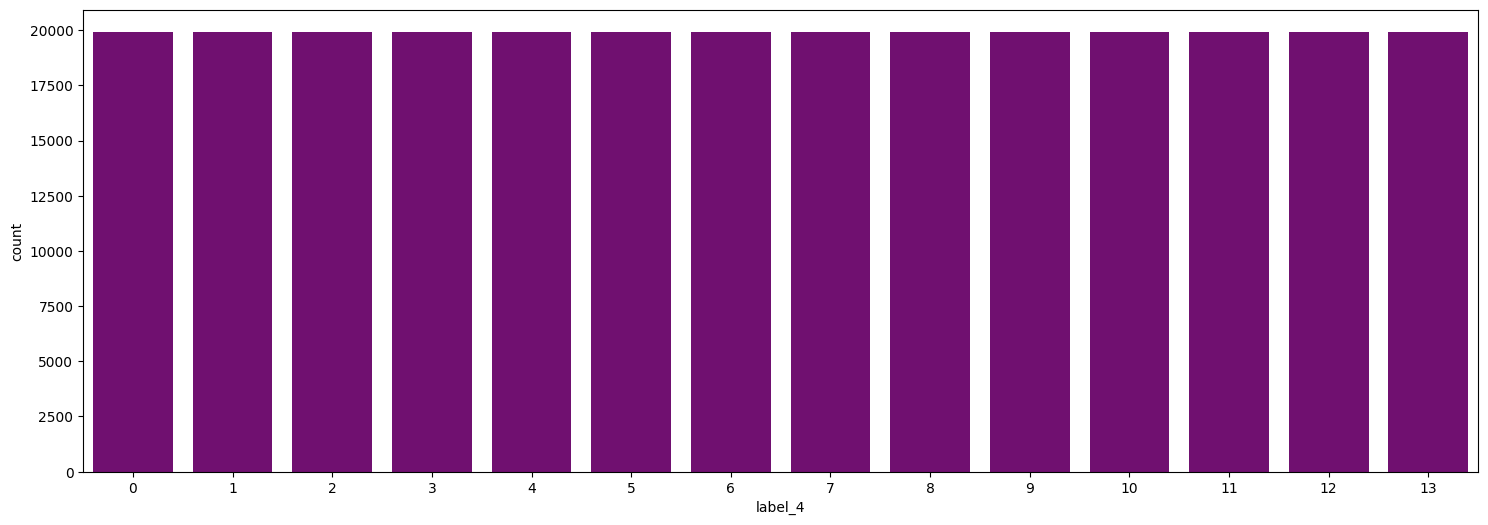

In [74]:
plt.figure(figsize=(18, 6))
sn.countplot(data=ros_train_label, x='label_4', color='purple')

## Before Feature Engineering

In [75]:
classify(models[0], 'label_4', train_features, valid_features, train_label, valid_label)

svm Accuracy Score for label_4 = 88.67%


0.8866666666666667

In [76]:
classify(models[1], 'label_4', train_features, valid_features, train_label, valid_label)

rfc Accuracy Score for label_4 = 74.13%


0.7413333333333333

In [77]:
classify(models[4], 'label_4', ros_train_features, valid_features, ros_train_label, valid_label)

knn Accuracy Score for label_4 = 95.87%


0.9586666666666667

## Feature Engineering

### Standardization

In [78]:
scaler = StandardScaler()

# Fit and transform the training data
train_standardized = scaler.fit_transform(train_features['label_4'])

# Transform the validation data using the same scaler
valid_standardized = scaler.transform(valid_features['label_4'])

# Transform the test data using the same scaler
test_standardized = scaler.transform(test_)

In [79]:
# standardize the random oversampled data
scaler = RobustScaler()

ros_train_standardized = scaler.fit_transform(ros_train_features['label_4'])
ros_valid_standardized = scaler.transform(valid_features['label_4'])
ros_test_standardized = scaler.transform(test_)

### PCA

In [80]:
threshold = 0.96
pca = PCA(threshold, svd_solver='full')


pca_train['label_4'] = pca.fit_transform(train_standardized)
pca_valid['label_4'] = pca.transform(valid_standardized)
pca_test['label_4'] = pca.transform(test_standardized)

explained_variance = pca.explained_variance_ratio_

retained_features_len = len(explained_variance)
print("Number of componenets for train data:", retained_features_len)

Number of componenets for train data: 350


In [81]:
# PCA with oversampled data
pca = PCA(threshold, svd_solver='full')

pca_ros_train = {}
pca_ros_valid = {}
pca_ros_test = {}

pca_ros_train['label_4'] = pca.fit_transform(ros_train_standardized)
pca_ros_valid['label_4'] = pca.transform(ros_valid_standardized)
pca_ros_test['label_4'] = pca.transform(ros_test_standardized)

explained_variance = pca.explained_variance_ratio_

retained_features_len = len(explained_variance)
print("Number of componenets for oversampled train data:", retained_features_len)

Number of componenets for oversampled train data: 333


In [82]:
classify(models[0], 'label_4', pca_train, pca_valid, train_label, valid_label)

svm Accuracy Score for label_4 = 89.07%


0.8906666666666667

In [83]:
classify(models[1], 'label_2', train_features, valid_features, train_label, valid_label)

rfc Accuracy Score for label_2 = 75.68%


0.7567934782608695

In [84]:
classify(models[4], 'label_4', pca_ros_train, pca_ros_valid, ros_train_label, valid_label)

knn Accuracy Score for label_4 = 94.67%


0.9466666666666667

## Hyper Parameter Tuning

In [85]:
X_train = pca_train['label_4']
X_valid = pca_valid['label_4']
y_train = train_label['label_4']
y_valid = valid_label['label_4']

In [86]:
param_distributions = {
    'C': np.logspace(-3, 3, 7),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': np.logspace(-3, 3, 7),
    'class_weight': ['balanced']
}

# Create an instance of the classifier
classifier = SVC()

# Call the function to perform random search and get the best accuracy and hyperparameters
best_model, best_accuracy, best_hyperparameters = random_grid_search_classifier(
    classifier, 
    X_train, 
    y_train, 
    param_distributions)

print("Best Model:", best_model)
print("Best Accuracy: %.2f%%" % (best_accuracy * 100))
print("Best Hyperparameters:", best_hyperparameters)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


Best Model: SVC(C=1000.0, class_weight='balanced', gamma=0.1, kernel='poly')
Best Accuracy: 81.59%
Best Hyperparameters: {'kernel': 'poly', 'gamma': 0.1, 'class_weight': 'balanced', 'C': 1000.0}


In [87]:
best_models['label_4'] = best_model

In [88]:
accuracy = get_classifier_predictions(best_models['label_4'], X_valid, y_valid)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.47%


In [89]:
# cross validation
classifier = SVC(**best_hyperparameters)

k_fold_cross_validation(classifier, 5, X_train, y_train)

Cross-Validation Scores: [0.94161992 0.92952314 0.9414446  0.94670407 0.92180926]
Mean Score: 0.9362201963534362
Standard Deviation: 0.009153017446849782


## Prediction

In [90]:
y_preds = {}

for label in labels:
    y_preds[label] = best_models[label].predict(pca_test[label])

In [91]:
id_list = test['ID']

result = {
    'ID': id_list,
    'label_1': y_preds['label_1'],
    'label_2': y_preds['label_2'],
    'label_3': y_preds['label_3'],
    'label_4': y_preds['label_4']
}

result_ = pd.DataFrame(result)

result_.to_csv('layer_9.csv', index=False)